## Load Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
# libgomp issue, must import n2 before torch
from n2 import HnswIndex

In [4]:
import sys

sys.path.insert(0, '..')

In [5]:
import os
home_dir = os.getenv('HOME')

https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution

In [6]:
import glob
import csv
from tqdm.auto import tqdm

row_dict = {}
rows_total = 2260

with tqdm(total=rows_total) as pbar:
    with open(f'{home_dir}/Downloads/affiliationstrings/affiliationstrings_ids.csv') as f:
        for row in csv.DictReader(f):
            row['id'] = int(row.pop('id1'))
            row_dict[row['id']] = row
            pbar.update(1)

In [7]:
true_pair_set = set()

with open(f'{home_dir}/Downloads/affiliationstrings/affiliationstrings_mapping.csv') as f:
    for row in csv.DictReader(f, fieldnames=['id1', 'id2']):
        true_pair_set.add(tuple(sorted([int(row['id1']), int(row['id2'])])))

len(true_pair_set)

16408

In [8]:
from entity_embed.data_utils.utils import id_pairs_to_cluster_mapping_and_dict

cluster_mapping, cluster_dict = id_pairs_to_cluster_mapping_and_dict(true_pair_set)
len(cluster_mapping)

2260

In [9]:
len(cluster_dict)

330

In [10]:
from entity_embed.data_utils.utils import cluster_dict_to_id_pairs

assert len(true_pair_set - cluster_dict_to_id_pairs(cluster_dict)) == 0

In [11]:
cluster_attr = 'cluster_id'

for row_id, row in tqdm(row_dict.items()):
    row[cluster_attr] = cluster_mapping[row_id]

In [12]:
row_dict[2727]

{'affil1': 'IBM Yamato Software Laboratory', 'id': 2727, 'cluster_id': 2727}

In [13]:
[row_dict[row_id] for row_id in cluster_dict[row_dict[2727]['cluster_id']]]

[{'affil1': 'IBM Yamato Software Laboratory', 'id': 2727, 'cluster_id': 2727},
 {'affil1': 'IBM Tokyo Research Lab, Tokyo, Japan',
  'id': 7609,
  'cluster_id': 2727},
 {'affil1': 'IBM Tokyo Research Laboratory', 'id': 2725, 'cluster_id': 2727}]

## Preprocess

In [14]:
attr_list = ['affil1']

In [15]:
import unidecode
from entity_embed import default_tokenizer

def clean_str(s):
    s = unidecode.unidecode(s).lower().strip()
    return ' '.join(s_part for s_part in default_tokenizer(s))

for row in tqdm(row_dict.values()):
    for attr in attr_list:
        row[attr] = clean_str(row[attr])

## Init Data Module

In [16]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [17]:
alphabet = list('0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ')

In [18]:
attr_info_dict = {
    'affil1': {
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
    }
}

In [19]:
from entity_embed import build_row_numericalizer

row_numericalizer = build_row_numericalizer(attr_info_dict, row_dict=row_dict)
row_numericalizer.attr_info_dict

15:30:48 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt


{'affil1': NumericalizeInfo(field_type=<FieldType.SEMANTIC_MULTITOKEN: 'semantic_multitoken'>, tokenizer=<function default_tokenizer at 0x7faf5e42dee0>, alphabet=None, max_str_len=None, vocab=<torchtext.vocab.Vocab object at 0x7faf35b14be0>)}

In [20]:
from entity_embed import DeduplicationDataModule

train_cluster_len = 100
valid_cluster_len = 100
test_cluster_len = len(cluster_dict) - valid_cluster_len - train_cluster_len
datamodule = DeduplicationDataModule(
    row_dict=row_dict,
    cluster_attr=cluster_attr,
    row_numericalizer=row_numericalizer,
    batch_size=10,
    row_batch_size=16,
    train_cluster_len=train_cluster_len,
    valid_cluster_len=valid_cluster_len,
    test_cluster_len=test_cluster_len,
    only_plural_clusters=True,
    random_seed=random_seed
)

## Training

In [21]:
from entity_embed import EntityEmbed

ann_k = 100
model = EntityEmbed(
    datamodule,
    ann_k=ann_k,
    use_mask=True,
    embedding_size=300
)

In [22]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

max_epochs = 100
early_stop_callback = EarlyStopping(
   monitor='valid_recall_at_0.3',
   min_delta=0.00,
   patience=20,
   verbose=True,
   mode='max'
)
tb_log_dir = 'tb_logs'
tb_name = 'affiliations'
trainer = pl.Trainer(
    gpus=1,
    max_epochs=max_epochs,
    check_val_every_n_epoch=1,
    callbacks=[early_stop_callback],
    logger=TensorBoardLogger(tb_log_dir, name=tb_name)
)

15:30:52 INFO:GPU available: True, used: True
15:30:52 INFO:TPU available: None, using: 0 TPU cores
15:30:52 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [23]:
trainer.fit(model, datamodule)

15:30:52 INFO:Train pair count: 5922
15:30:52 INFO:Valid pair count: 3867
15:30:52 INFO:Test pair count: 7006
15:30:55 INFO:
  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 935 K 
1 | losser      | SupConLoss | 0     
-------------------------------------------
407 K     Trainable params
528 K     Non-trainable params
935 K     Total params


1

In [24]:
from entity_embed import validate_best

validate_best(trainer)

{'valid_f1_at_0.3': 0.14987028135872732,
 'valid_f1_at_0.5': 0.2391397565722202,
 'valid_f1_at_0.7': 0.6745610453246224,
 'valid_f1_at_0.9': 0.7586303676676958,
 'valid_pair_entity_ratio_at_0.3': 67.53460972017673,
 'valid_pair_entity_ratio_at_0.5': 38.954344624447714,
 'valid_pair_entity_ratio_at_0.7': 8.731958762886597,
 'valid_pair_entity_ratio_at_0.9': 4.799705449189985,
 'valid_precision_at_0.3': 0.08125436147941381,
 'valid_precision_at_0.5': 0.13705103969754254,
 'valid_precision_at_0.7': 0.5572609208972845,
 'valid_precision_at_0.9': 0.8293955200981896,
 'valid_recall_at_0.3': 0.9635376260667183,
 'valid_recall_at_0.5': 0.9374191880010344,
 'valid_recall_at_0.7': 0.8544091026635635,
 'valid_recall_at_0.9': 0.6989914662529092}

In [25]:
import gc
del trainer
gc.collect()

177

## Testing manually 

In [26]:
datamodule.setup(stage='test')

15:32:17 INFO:Train pair count: 5922
15:32:17 INFO:Valid pair count: 3867
15:32:17 INFO:Test pair count: 7006


In [27]:
test_row_dict = datamodule.test_row_dict
test_vector_dict = model.predict(
    row_dict=test_row_dict,
    batch_size=16
)

In [28]:
embedding_size = model.blocker_net.embedding_size
test_true_pair_set = datamodule.test_true_pair_set

In [29]:
import gc
del model
del datamodule
gc.collect()

779

In [30]:
assert len(test_vector_dict) == len(test_row_dict)

In [31]:
%%time

from entity_embed import ANNEntityIndex

ann_index = ANNEntityIndex(embedding_size=embedding_size)
ann_index.insert_vector_dict(test_vector_dict)
ann_index.build()

CPU times: user 197 ms, sys: 5.46 ms, total: 202 ms
Wall time: 43.4 ms


In [32]:
%%time

sim_threshold = 0.3
found_pair_set = ann_index.search_pairs(
    k=ann_k,
    sim_threshold=sim_threshold
)

CPU times: user 356 ms, sys: 16.4 ms, total: 372 ms
Wall time: 71.8 ms


In [33]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(found_pair_set), len(test_row_dict))

66.72433679354094

In [34]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(found_pair_set, test_true_pair_set)

(0.11249783923941227, 0.928918070225521)

In [35]:
false_positives = list(found_pair_set - test_true_pair_set)
len(false_positives)

51342

In [36]:
false_negatives = list(test_true_pair_set - found_pair_set)
len(false_negatives)

498

In [37]:
cos_similarity = lambda a, b: np.dot(a, b)

In [38]:
for (id_left, id_right) in false_negatives[:10]:
    display(
        (
            cos_similarity(test_vector_dict[id_left], test_vector_dict[id_right]),
            row_dict[id_left], row_dict[id_right]
        )
    )

(0.2508892,
 {'affil1': 'department of computer science , university of maryland',
  'id': 1423,
  'cluster_id': 3452},
 {'affil1': 'department of computer science , university of helsinki , finland',
  'id': 8174,
  'cluster_id': 3452})

(0.4684608,
 {'affil1': 'university of california at santa barbara , santa barbara , ca',
  'id': 2732,
  'cluster_id': 3202},
 {'affil1': 'university of california , davis , department of computer science , one shields avenue , davis , ca 95616 , usa ; e - mail : gertz @ cs . ucdavis . edu',
  'id': 7866,
  'cluster_id': 3202})

(0.44910303,
 {'affil1': 'u . c . berkeley , intel research , berkeley',
  'id': 4199,
  'cluster_id': 903},
 {'affil1': 'university of california , usa', 'id': 8359, 'cluster_id': 903})

(0.23044334,
 {'affil1': 'university of maryland', 'id': 3452, 'cluster_id': 3452},
 {'affil1': 'department of computer science , university of helsinki , finland',
  'id': 8174,
  'cluster_id': 3452})

(0.48381352,
 {'affil1': 'university of california , santa barbara , ca',
  'id': 45,
  'cluster_id': 3202},
 {'affil1': 'university of california , davis , department of computer science , one shields avenue , davis , ca 95616 , usa ; e - mail : gertz @ cs . ucdavis . edu',
  'id': 7866,
  'cluster_id': 3202})

(0.24698383,
 {'affil1': 'university of helsinki , finland',
  'id': 8286,
  'cluster_id': 3452},
 {'affil1': 'university of maryland , college park , usa',
  'id': 8682,
  'cluster_id': 3452})

(0.0,
 {'affil1': 'bayerisches forschungszentrum fur wissensbasierte systeme , orleansstra , munchen , germany',
  'id': 1140,
  'cluster_id': 1140},
 {'affil1': 'forwiss', 'id': 3532, 'cluster_id': 1140})

(0.35983518,
 {'affil1': 'lawrence berkeley national laboratory , berkeley , ca',
  'id': 1707,
  'cluster_id': 903},
 {'affil1': 'intel research , berkeley , ca', 'id': 8198, 'cluster_id': 903})

(0.47482127,
 {'affil1': 'at & t labs research ; e - mail : suciu @ research . att . com',
  'id': 7733,
  'cluster_id': 7710},
 {'affil1': 'at & t labs & mdash ;&# 8212 ; research , florham park , nj',
  'id': 9400,
  'cluster_id': 7710})

(0.4884098,
 {'affil1': 'information sciences research center , bell laboratories , 600 mountain avenue , murray hill nj',
  'id': 6602,
  'cluster_id': 6476},
 {'affil1': 'lucent technologies , bell labs', 'id': 7392, 'cluster_id': 6476})

## t-sne visualization

In [39]:
vis_sample_size = 10

In [40]:
from entity_embed.data_utils.utils import row_dict_to_cluster_dict

test_cluster_dict = row_dict_to_cluster_dict(test_row_dict, cluster_attr)
vis_cluster_dict = dict(sorted(test_cluster_dict.items(), key=lambda x: len(x[1]), reverse=True)[:vis_sample_size])

In [41]:
vis_x = np.stack([test_vector_dict[id_] for cluster in vis_cluster_dict.values() for id_ in cluster])
vis_y = [test_row_dict[cluster[0]]['affil1'] for cluster_id, cluster in vis_cluster_dict.items() for id_ in cluster]

In [42]:
from sklearn.manifold import TSNE

tnse = TSNE(metric='cosine', perplexity=20, random_state=random_seed)
tsne_results = tnse.fit_transform(vis_x)

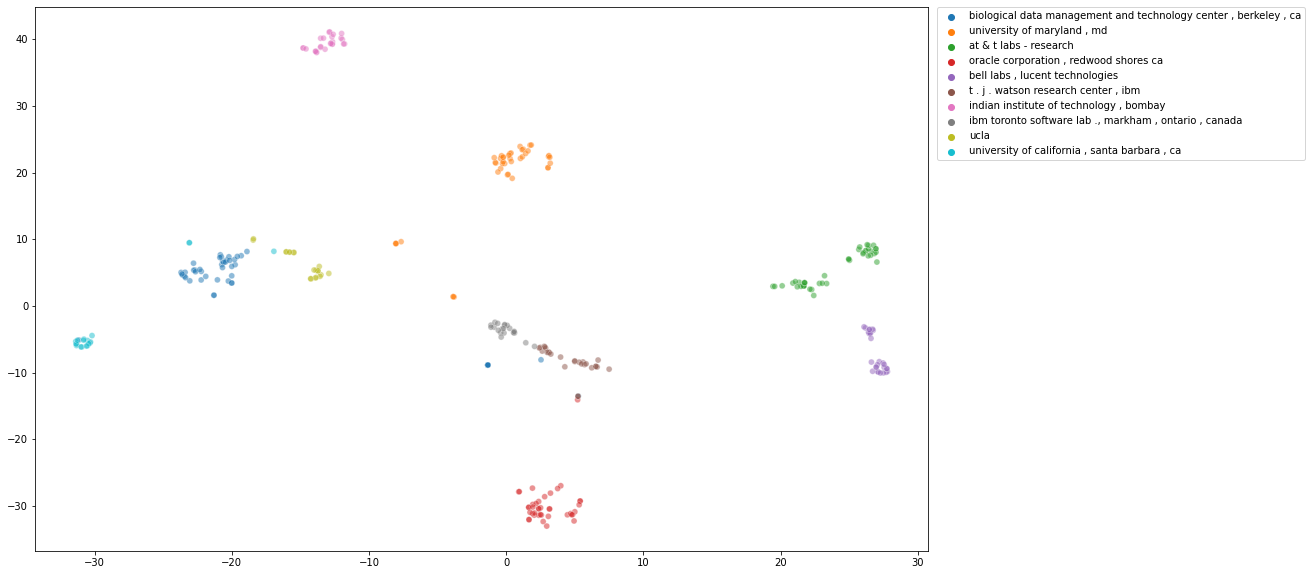

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    hue=vis_y,
    palette=sns.color_palette("tab10", len(vis_cluster_dict.keys())),
    legend="full",
    alpha=0.5,
)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.);